In [1]:
from functools import partial

import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from flowjax.distributions import Normal, Transformed
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_variational_target
from jax import vmap
from numpyro.infer import Predictive
from numpyro.infer.util import log_density

from gnpe.losses import AmortizedMaximumLikelihood, ContrastiveLoss
from gnpe.models import (
    LocScaleHierarchicalGuide,
)
from gnpe.numpyro_utils import prior_log_density
from gnpe_experiments.plot_utils import pairplot_dictionary
from gnpe_experiments.utils import init_to_small
from gnpe_experiments.tasks.sirsde.sirsde import get_hierarchical_sir_model

n_obs = 20
key = jr.PRNGKey(0)

In [2]:
# Recreate model with surrogate likelihood, and unbounded theta
model = get_hierarchical_sir_model(n_obs=n_obs)

In [3]:
pred = Predictive(model, num_samples=1)
key, subkey = jr.split(key)
observations = pred(subkey)

# Drop num samples dimension of 1
observations = {k: v.squeeze(0) for k, v in observations.items()}
assert not any(jnp.isnan(arr).any() for arr in observations.values())

In [5]:
z_dim = model.likelihood.cond_shape[0]
z_embedded_dim = z_dim
x_dim = model.likelihood.shape[0]

key, subkey = jr.split(key)
loc = masked_autoregressive_flow(
        key=subkey,
        base_dist=Normal(jnp.zeros(z_dim)),
        cond_dim=z_embedded_dim,
    )

z_embedding_net = eqx.nn.MLP(
    in_size=z_dim,
    out_size=z_embedded_dim,
    width_size=20,
    depth=1,
    key=subkey,
)

z_guide = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros((z_dim,))),
    cond_dim=x_dim,
    )

scale = masked_autoregressive_flow(
        key=subkey,
        base_dist=Normal(jnp.zeros(z_dim)),
        cond_dim=z_embedded_dim,
    )

guide = LocScaleHierarchicalGuide(
    loc_base=loc,
    scale_base=scale,
    z=z_guide,
    z_embedding_net=z_embedding_net,
    n_obs=n_obs,
)

guide = init_to_small(guide, subkey)

100%|██████████| 4000/4000 [02:03<00:00, 32.39it/s, loss=237]    


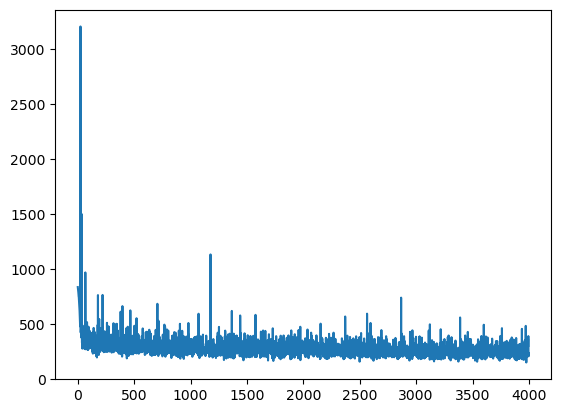

In [6]:
# Pretrain using amortized maximum likelihood
steps=4000

loss = AmortizedMaximumLikelihood(
    model=model,
    observed_name="x",
)

optimizer = optax.apply_if_finite(
    optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(optax.linear_schedule(5e-3, 5e-4, steps)),
    ),
    max_consecutive_errors=10,
    )

guide, losses = fit_to_variational_target(
    subkey,
    dist=guide,
    loss_fn=loss,
    steps=steps,
    optimizer=optimizer,
    )
plt.plot(jnp.array(losses)[jnp.array(losses)<=1e4])


In [7]:
log_density(
    guide,
    model_args=(),
    model_kwargs={"obs": observations["x"]},
    params={k: v for k, v in observations.items() if k!="x"},
    )[0].item()

-19.224567413330078

In [12]:
from gnpe_experiments.metrics import sample_posterior
from gnpe_experiments.tasks.sirsde.sirsde import SIRSDE, get_sir_processors
from numpyro.infer import Predictive


def plot_results(guide, n: int = 400):

    prior_and_predictive = Predictive(model, num_samples=n)(key) # TODO key handling
    processors = get_sir_processors()

    posterior_and_predictive = sample_posterior(
        key=jr.PRNGKey(0),
        guide=guide,
        obs=observations["x"],
        n=n,
        model=model,
        )
    
    # Global plot
    for var_name, dim, col_names in [
        ("z", z_dim, SIRSDE.z_names),
        ("x", x_dim, SIRSDE.x_names),
        ]:
        plot_data = {
            "prior": prior_and_predictive[var_name].reshape(-1, dim),
            "posterior": posterior_and_predictive[var_name].reshape(-1, dim)[:n],
            "observations": observations[var_name],
            }
        
        if var_name in processors:
            plot_data = {
                k: vmap(processors[var_name].inverse)(v) for k, v in plot_data.items()
                }

        pairplot_dictionary(
            plot_data,
            equalize_points=False,
            shuffle=False,
            column_names=col_names,
        )
    plt.show()

    # Plot posterior for a specific observation
    obs_id = 0

    for var_name, col_names in [
        ("z", SIRSDE.z_names), ("x", SIRSDE.x_names),
        ]:

        plot_data = {
            "prior": prior_and_predictive[var_name][:, obs_id, :],
            "posterior": posterior_and_predictive[var_name][:, obs_id, :],
            "observations": observations[var_name][obs_id, :],
            }
            
        if var_name in processors:

            plot_data = {
                k: jnp.vectorize(
                    processors[var_name].inverse, signature="(a)->(b)",
                    )(v) for k, v in plot_data.items()
                }  # TODO why are we doing this twice?

        pairplot_dictionary(
            plot_data,
            column_names=col_names,
        )
    plt.show()


/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

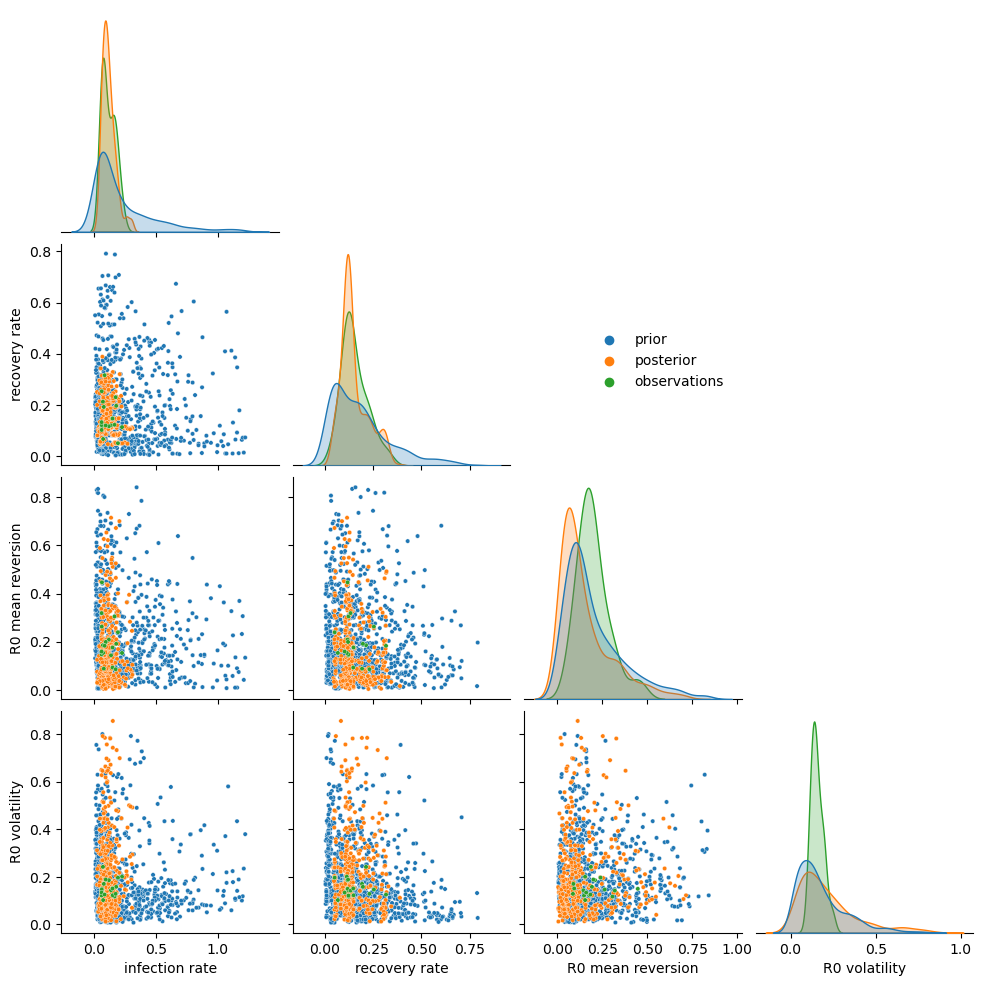

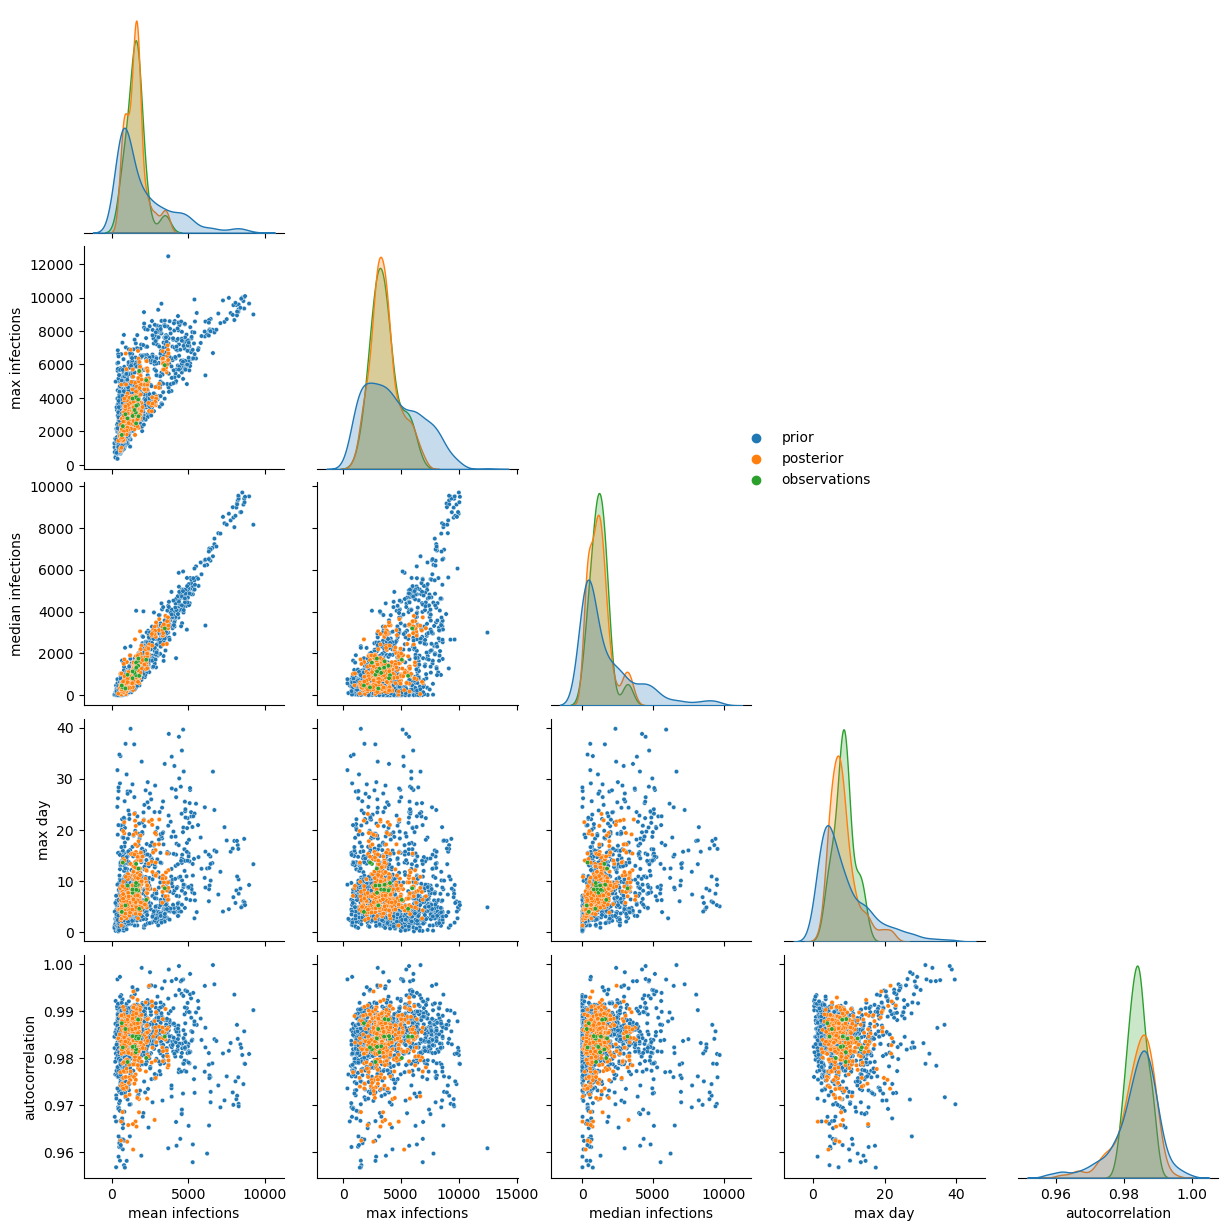

/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

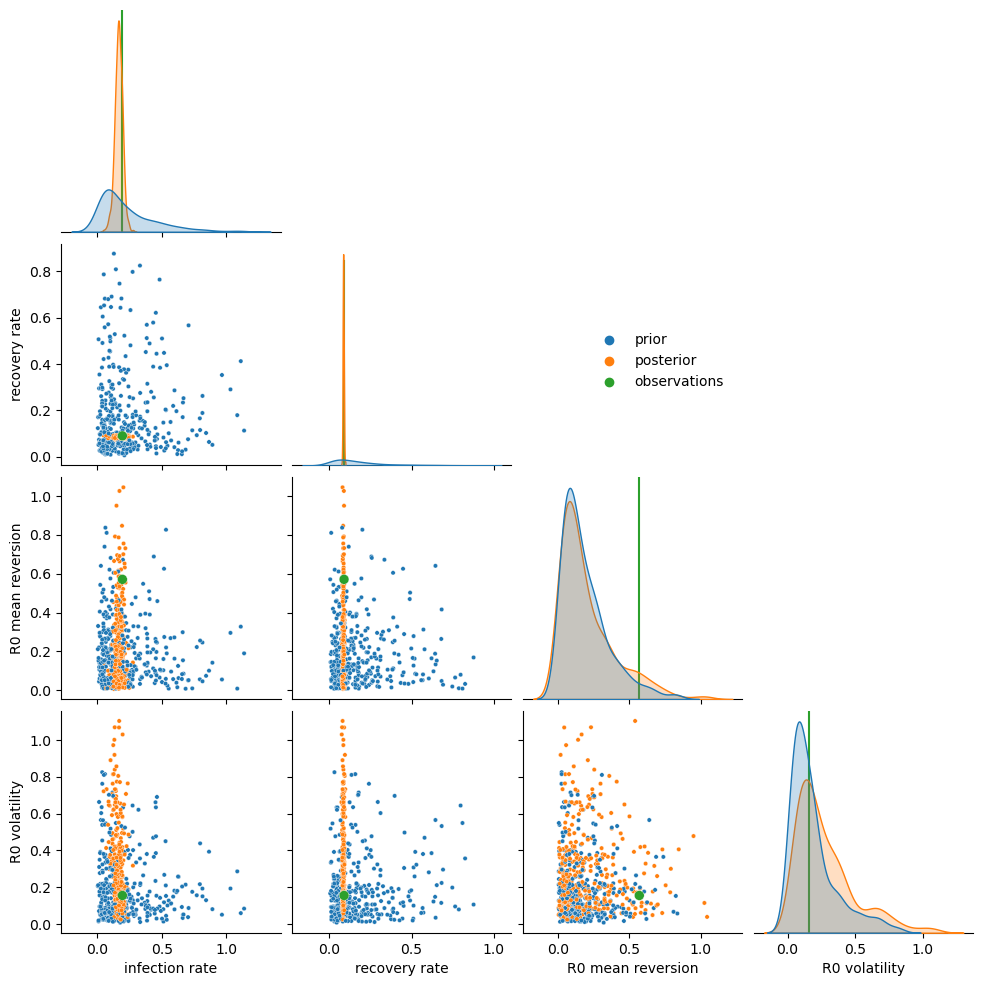

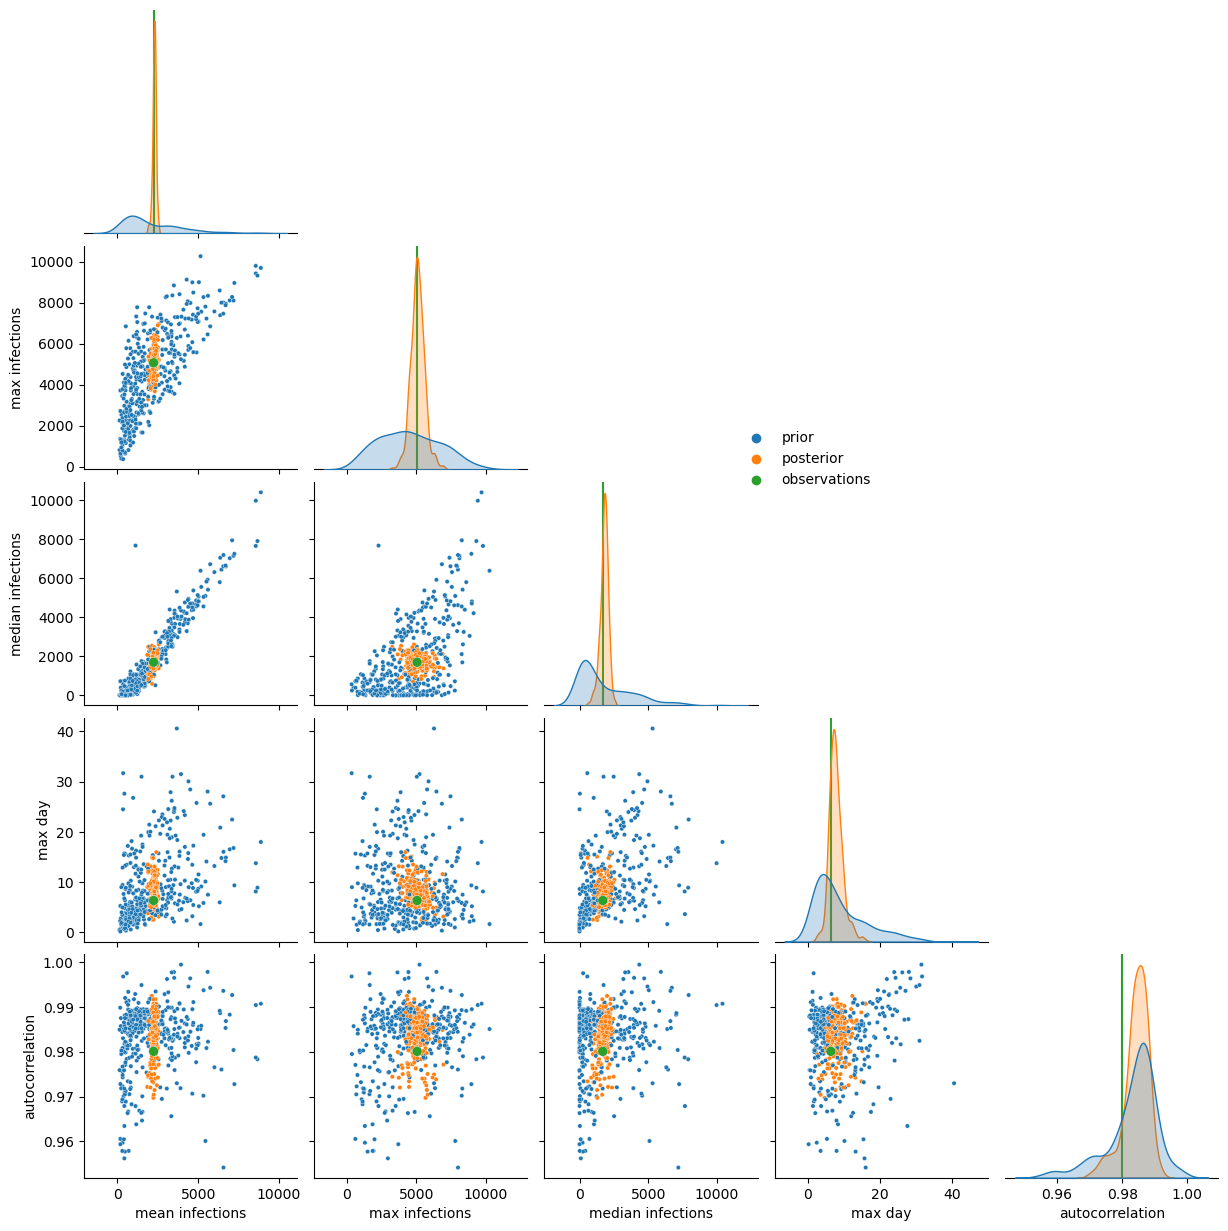

In [13]:
plot_results(guide)

In [14]:
# Fine tune with contrastive loss
loss = ContrastiveLoss(
    model=model,
    obs=observations["x"],
    obs_name="x",
    n_contrastive=10,
)

In [15]:
key, subkey = jr.split(key)

optimizer = optax.apply_if_finite(
    optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-4),
    ),
    max_consecutive_errors=500,
    )

guide, losses = fit_to_variational_target(
    subkey,
    dist=guide,
    loss_fn=loss,
    steps=500,
    optimizer=optimizer,
    return_best=False,
    )


100%|██████████| 500/500 [01:14<00:00,  6.74it/s, loss=187]    


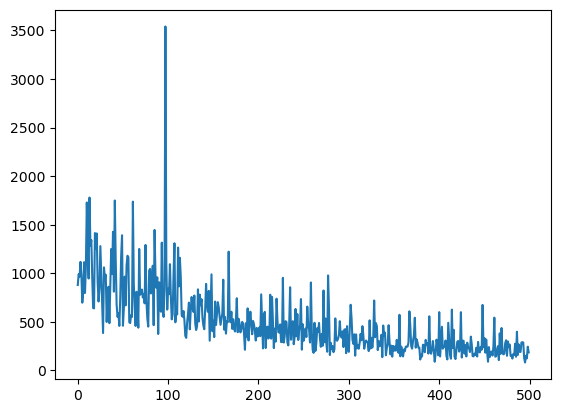

In [16]:
plt.plot(jnp.asarray(losses).ravel())

In [18]:
from gnpe_experiments.metrics import posterior_probability_true

posterior_probability_true(
    guide,
    true_latents={k: v for k, v in observations.items() if k!="x"},
    obs=observations["x"],
    )[0]

Array(-84.94974, dtype=float32)

In [19]:
prior_log_density(
    partial(model, obs=observations["x"]),
    data={k: v for k, v in observations.items() if k!="x"},
    observed_nodes=["x"],
)

Array(-41.82337, dtype=float32)

/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

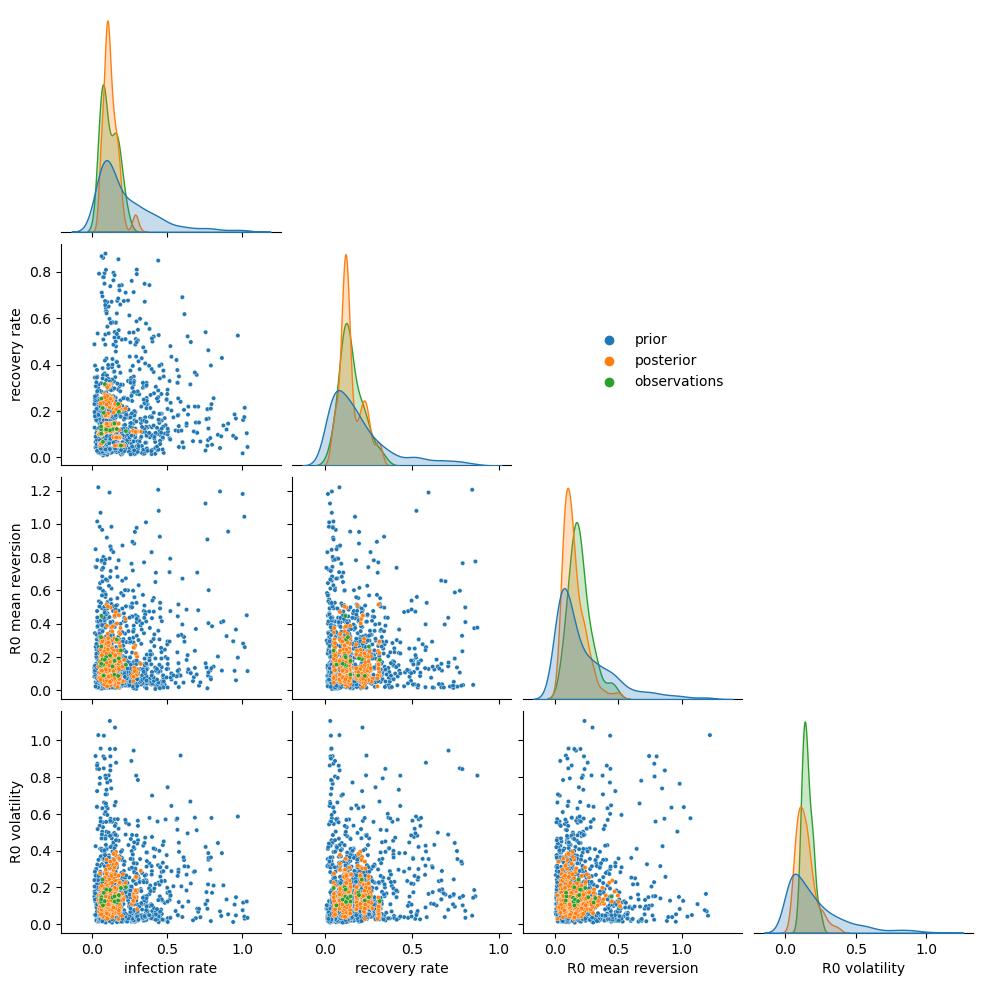

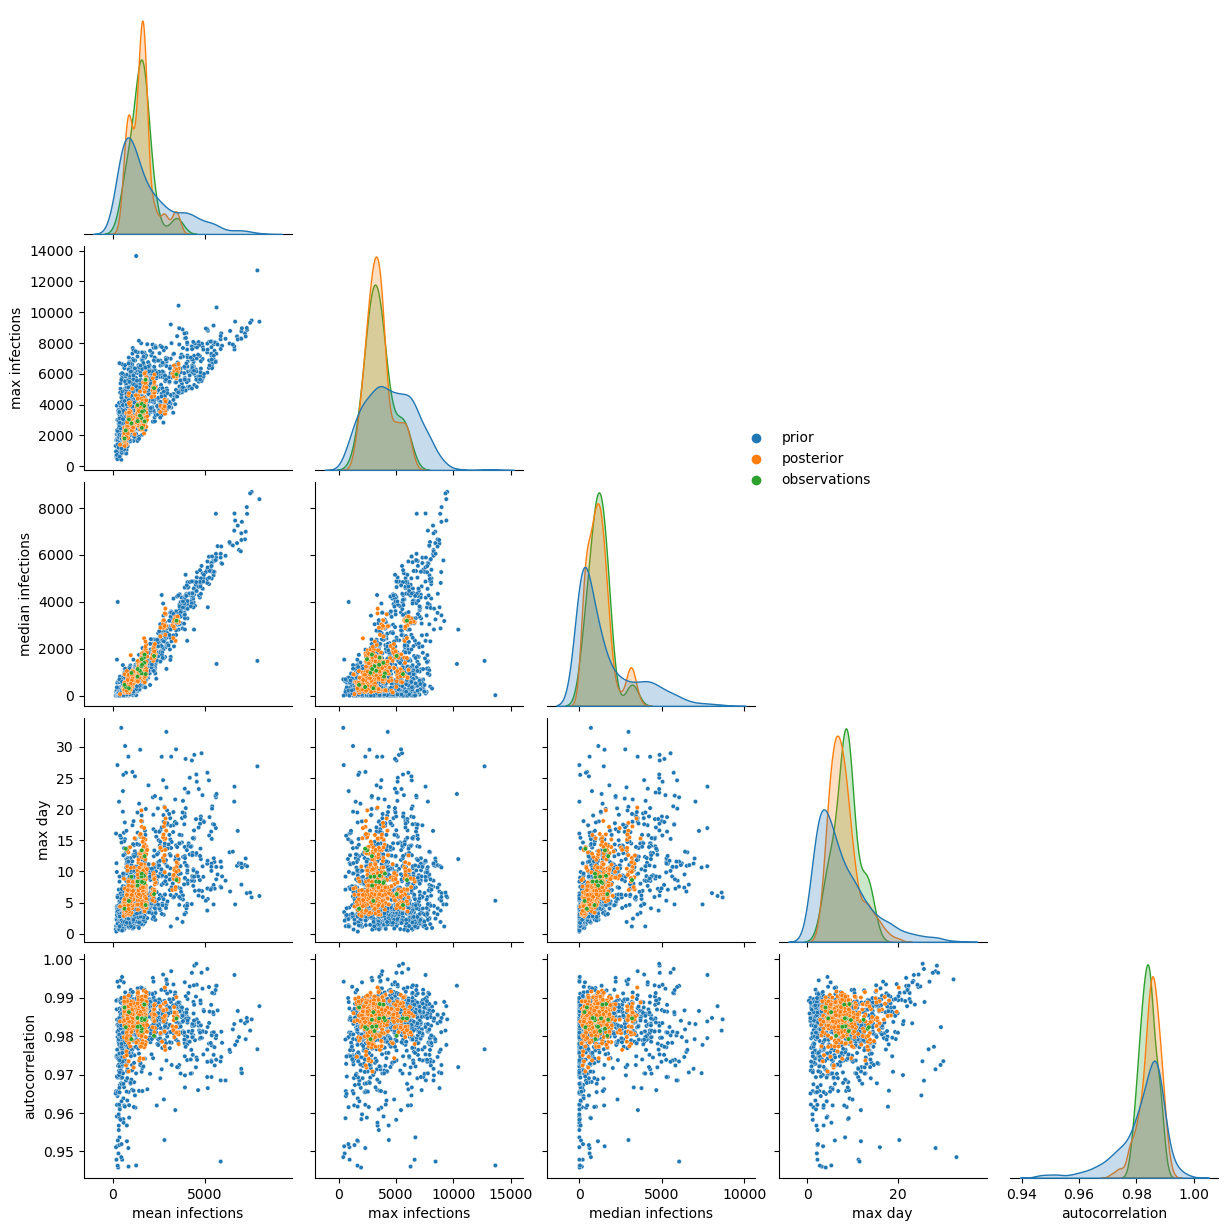

/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/dw16200/miniconda3/envs/jax_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option i

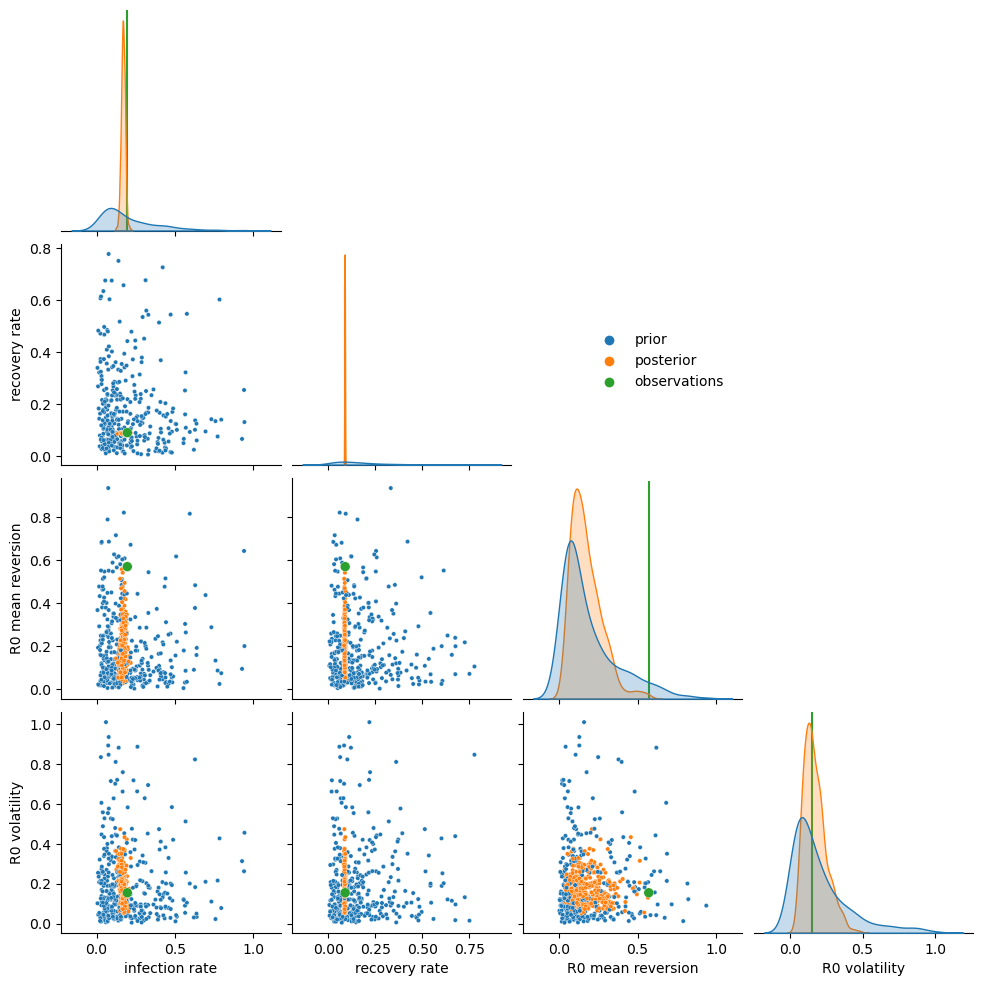

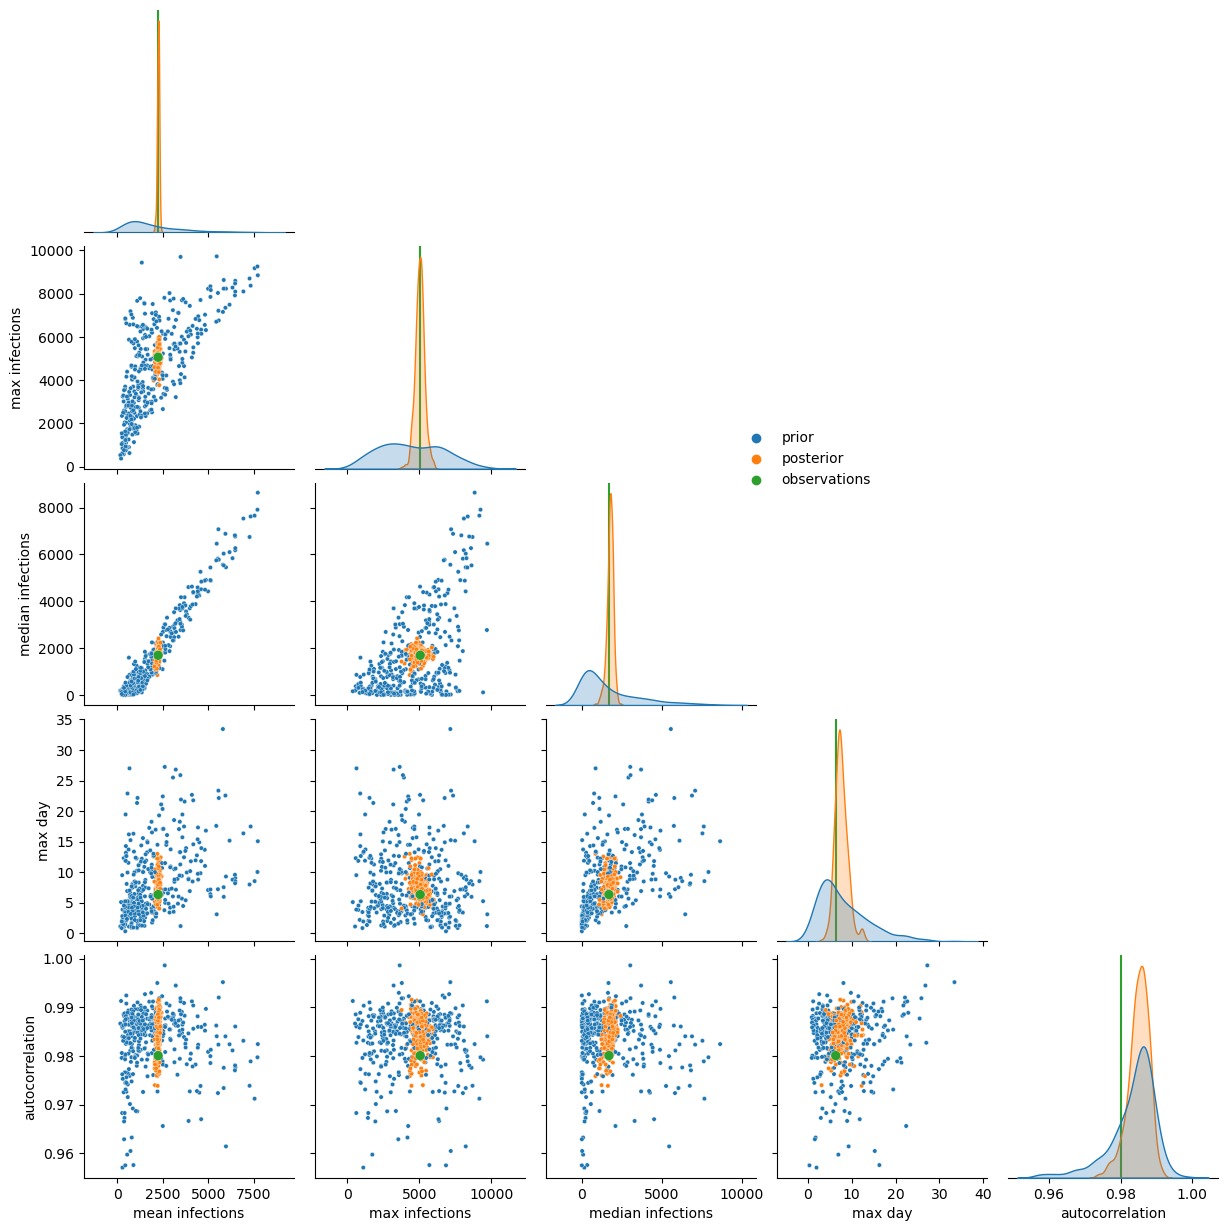

In [20]:
plot_results(guide)